# Self-Attention and Positional Encoding

Self-attention is a mechanism used in neural networks to help the model focus on different parts of the input data when generating each part of the output. It is a key component of the Transformer architecture, which is widely used in natural language processing tasks such as machine translation, text summarization, and sentiment analysis.

The idea behind self-attention is to allow the model to weigh the importance of each input token when generating each output token. This is done by computing a weighted sum of the input tokens, where the weights are determined by the relationships between all pairs of input tokens.

In [1]:
# @title Installing required libraries
%%capture
! pip install Levenshtein
! pip install matplotlib
!pip install torch==2.3.0 torchtext==0.18.0

In [2]:
# @title Importing required libraries

%%capture
import os
import sys
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Self Attention

In [3]:
# Define a function to visualize the learned embeddings in a 3D space using matplotlib.
# This helps in understanding how the embeddings cluster and separate different tokens,
# providing insight into what the model has learned.

def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [4]:
# @title A Simple Dictionary to map French words to their English equivalents

dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}

In [5]:
# Create and sort the input vocabulary from the dictionary's keys
vocabulary_in = sorted(list(set(dictionary.keys())))
# Display the size and the sorted vocabulary for the input language
print(f"Vocabulary input ({len(vocabulary_in)}): {vocabulary_in}")

# Create and sort the output vocabulary from the dictionary's values
vocabulary_out = sorted(list(set(dictionary.values())))
# Display the size and the sorted vocabulary for the output language
print(f"Vocabulary output ({len(vocabulary_out)}): {vocabulary_out}")

Vocabulary input (6): ['chat', 'est', 'la', 'le', 'sous', 'table']
Vocabulary output (5): ['cat', 'is', 'table', 'the', 'under']


In [6]:
# @title The tokenize function is responsible for breaking down a sentence into individual words.
def tokenize(text):
    """
    This function takes a string of text as input and returns a list of words (tokens).
    It uses the split method, which by default splits on any whitespace, to tokenize the text.
    """
    return text.split()  # Split the input text on whitespace and return the list of tokens

In [7]:
# @title Encode tokens using 'one hot' encoding.

# Function to convert a list of vocabulary words into one-hot encoded vectors
def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)  # Get the size of the vocabulary
    one_hot = dict()  # Initialize a dictionary to hold our one-hot encodings
    LEN = len(vocabulary)  # The length of each one-hot encoded vector will be equal to the vocabulary size

    # Iterate over the vocabulary to create a one-hot encoded vector for each word
    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector
        print(f"{key}\t: {one_hot[key]}")  # Print each word and its encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

In [8]:
# Apply the one-hot encoding function to the input vocabulary and store the result

one_hot_in = encode_one_hot(vocabulary_in)

chat	: tensor([1., 0., 0., 0., 0., 0.])
est	: tensor([0., 1., 0., 0., 0., 0.])
la	: tensor([0., 0., 1., 0., 0., 0.])
le	: tensor([0., 0., 0., 1., 0., 0.])
sous	: tensor([0., 0., 0., 0., 1., 0.])
table	: tensor([0., 0., 0., 0., 0., 1.])


In [9]:
# Apply the one-hot encoding function to the output vocabulary and store the result
# This time we're encoding the target language vocabulary
one_hot_out = encode_one_hot(vocabulary_out)

cat	: tensor([1., 0., 0., 0., 0.])
is	: tensor([0., 1., 0., 0., 0.])
table	: tensor([0., 0., 1., 0., 0.])
the	: tensor([0., 0., 0., 1., 0.])
under	: tensor([0., 0., 0., 0., 1.])


In [10]:
# @title Stacking the one-hot encoded vectors for input vocabulary to form a tensor
K = torch.stack([one_hot_in[k] for k in dictionary.keys()])
# K now represents a matrix of one-hot vectors for the input vocabulary

# Display the tensor for verification
print(K)

tensor([[0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [11]:
# @title Stack the one-hot encoded vectors for output vocabulary to form a tensor

V = torch.stack([one_hot_out[k] for k in dictionary.values()])
# V represents the corresponding matrix of one-hot vectors for the output vocabulary

# Display the tensor for verification
print(V)

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


In [12]:
def decode_one_hot(one_hot, vector):
    """
    Decode a one-hot encoded vector to find the best matching token in the vocabulary.
    """
    best_key, best_cosine_sim = None, 0
    for k, v in one_hot.items():  # Iterate over the one-hot encoded vocabulary
        cosine_sim = torch.dot(vector, v)  # Calculate dot product (cosine similarity)
        if cosine_sim > best_cosine_sim:  # If this is the best similarity we've found
            best_cosine_sim, best_key = cosine_sim, k  # Update the best similarity and token
    return best_key  # Return the token corresponding to the one-hot vector

### Translation with attention mechanism
The `translate` function use matrix multiplication across the entire sentence. Instead of translating word by word, it now uses the "Q" matrix to perform the operation in parallel for all words.

In [13]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication in parallel.
    A single matrix multiplication step applies the attention mechanism
    across all tokens at once.
    """
    # Tokenize the sentence and stack the one-hot vectors to form the Q matrix
    Q = torch.stack([one_hot_in[token] for token in tokenize(sentence)])

    # Apply softmax to the dot product of Q and K.T and multiply by V
    # This will give us the output vectors for all tokens in parallel
    out = torch.softmax(Q @ K.T, 0) @ V

    # Decode each one-hot vector in the output to the corresponding token
    # And join the tokens to form the translated sentence
    return ' '.join([decode_one_hot(one_hot_out, o) for o in out])

# Test the function to ensure it produces the correct translation
translate("le chat est sous la table")

'the cat is under the table'

## Self-attention class

Create self-attention heads from scratch.

You can also create self-attention heads using PyTorch transformer models in `nn.torch`.

$$
Attention(Q, K, V)  => Attention(Q \cdot W^Q, K \cdot W^K, V \cdot W^V)
$$

In [14]:
class Head(nn.Module):
    """ Self attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures. """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Linear layers to compute the queries, keys, and values from the embeddings
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        return embedded_x,k,q,v,w

    def forward(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        # Add weighted values
        out = w @ v
        return out

In [15]:
# @title Dataset definition

dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

### Tokenization setup
A tokenizer is created using `torchtext`'s `get_tokenizer` function which will break down strings into tokens (words).

In [16]:
tokenizer = get_tokenizer("basic_english")  # Get a basic English tokenizer

In [17]:
# @title Vocabulary Building

def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

In [18]:
# A text_pipeline function is defined to convert raw text strings
# into token indices using the tokenizer and the vocabulary.

def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    return vocab(tokenizer(x))  # Tokenize the input and map each token to its index in the vocabulary

In [19]:
# @title Hyperparameter Definition

vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

In [20]:
# @title Dummy Test.

# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

# Print the size of the resulting embedded vector for verification
print(embedded_x.shape)  # Should show the shape as [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)  # The actual embedded representations of the input tokens

# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

# Now we actually pass the input data through the entire attention head to get the output
output = attention_head(input_data)

# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5])
tensor([12, 13, 15, 11, 14])
torch.Size([5, 3])
embedded_x: tensor([[-1.3226,  0.1493, -0.6192],
        [-0.3820,  0.4547,  0.6820],
        [ 1.6620,  1.7519, -0.0656],
        [-1.9121,  2.1961,  1.4958],
        [-1.5304, -0.9069,  0.3528]], grad_fn=<EmbeddingBackward0>)
k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])
torch.Size([5, 3])
tensor([[-0.1655, -0.1847,  0.1462],
        [-0.2970, -0.0676,  0.2284],
        [-0.5403, -0.1550,  0.3689],
        [-0.3870, -0.0684,  0.2817],
        [-0.1611, -0.0763,  0.1509]], grad_fn=<MmBackward0>)


## Positional Encoding

To illustrate, consider the sentences: 'He painted the car red' and 'He painted the red car.' These sentences have different meanings due to the different positions of the words 'red' and 'car.' Properly implemented positional encodings would allow the model to distinguish between the positions of these words, ensuring that the embeddings for these sentences are distinct.

In sequence processing tasks, it's crucial for the model to understand the positions of elements within a sequence. Achieve this by associating each sample with a unique position index, denoted as
, where
 represents the sample's position in the sequence. To elaborate, let's consider a sequence of elements. Start by assigning index 0 to the first element, index 1 to the second, and so forth. This simple yet effective technique enables the model to grasp the relative positions of elements in the sequence. Importantly, this method remains reliable even when dealing with long sequences, extending as far as our vocabulary allows. By incorporating positional encodings, our model gains a deep understanding of the order and arrangement of elements, enhancing its performance in various sequence-related tasks.

The position printed below incorporates the whole length of the vocabulary size.

In [21]:
# Generate a range of position indices from 0 to the size of the vocabulary
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)

# Retrieve the list of words from the vocabulary object
vocab_list = list(vocab.get_itos())

# Iterate over the range of vocabulary size
for idx in range(vocab_size):
    word = vocab_list[idx]  # Get the word from the vocabulary list at the current index
    pos = position[idx][0].item()  # Extract the numerical value of the position index from the tensor
    print(f"Word: {word}, Position Index: {pos}")

Word: <unk>, Position Index: 0.0
Word: nlp, Position Index: 1.0
Word: pytorch, Position Index: 2.0
Word: analysis, Position Index: 3.0
Word: entity, Position Index: 4.0
Word: machine, Position Index: 5.0
Word: named, Position Index: 6.0
Word: sentiment, Position Index: 7.0
Word: translation, Position Index: 8.0
Word: with, Position Index: 9.0
Word: ,, Position Index: 10.0
Word: car, Position Index: 11.0
Word: he, Position Index: 12.0
Word: painted, Position Index: 13.0
Word: red, Position Index: 14.0
Word: the, Position Index: 15.0
Word: basics, Position Index: 16.0
Word: classification, Position Index: 17.0
Word: for, Position Index: 18.0
Word: introduction, Position Index: 19.0
Word: of, Position Index: 20.0
Word: recognition, Position Index: 21.0
Word: techniques, Position Index: 22.0
Word: text, Position Index: 23.0
Word: to, Position Index: 24.0
Word: using, Position Index: 25.0
Word: vs, Position Index: 26.0


In positional encodings, each dimension \(d\) within the embedding holds specific importance, denoted as $\textbf{p}_{n,d}$. For example, if you have an embedding dimension of three, the positional encodings $\textbf{p}_{n,d}$ ​are represented as $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$. These values correspond to a three-dimensional embedding for each token, capturing its position and unique characteristics within the sequence. By organizing positional information this way, the model gains a richer understanding of the relationship between tokens.


In [22]:
# Initialize a matrix of zeros with dimensions [vocab_size, n_embd]
# This will be used to hold the positional encodings for each word in the vocabulary
pe = torch.zeros(vocab_size, n_embd)

# Concatenate the position tensor three times along dimension 1 (columns)
# This simplistic example is likely a placeholder for a more complex function of position that would be used in a real positional encoding
pe = torch.cat((position, position, position), 1)

# Display the positional encoding tensor
# In an actual implementation, this would involve a more sophisticated method that reflects the position's impact on the embeddings
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

In [23]:
# Obtain the shape of the embedded_x tensor which contains the embedded representations
# 'samples' will hold the number of tokens/samples in the batch
# 'dim' will hold the dimensionality of the embeddings
samples, dim = embedded_x.shape

# Print the tuple (samples, dim) to show the size of the batch and the embedding dimension
samples, dim

(5, 3)

In [24]:
# Select the appropriate positional encodings based on the number of samples and embedding dimensions
# This slice of the positional encoding tensor 'pe' corresponds to the actual batch size and embedding size
pe_slice = pe[0:samples, 0:n_embd]

In [25]:
# Add the positional encodings to the token embeddings
# This step integrates the position information into the embeddings
pos_embding = embedded_x + pe_slice

# The result 'pos_embding' now contains the token embeddings adjusted with positional information
# Display the adjusted embeddings tensor
pos_embding

tensor([[-1.3226,  0.1493, -0.6192],
        [ 0.6180,  1.4547,  1.6820],
        [ 3.6620,  3.7519,  1.9344],
        [ 1.0879,  5.1961,  4.4958],
        [ 2.4696,  3.0931,  4.3528]], grad_fn=<AddBackward0>)

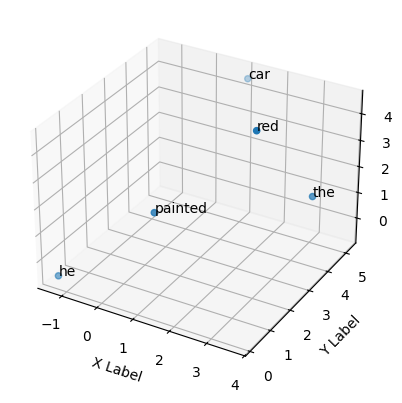

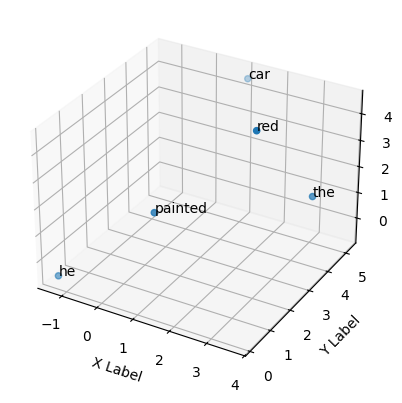

In [26]:
# Visualize the embeddings with positional encodings using the defined plot function
# 'pos_embding.detach().numpy()' converts the embeddings tensor to a NumPy array and detaches it from the current computation graph
# 'tokenizer(my_tokens)' tokenizes the sample sentence for labeling in the plot
# 'vocab' is passed to associate tokens with their embeddings for plotting
plot_embdings(pos_embding.detach().numpy(), tokenizer(my_tokens), vocab)
plot_embdings(pos_embding.detach().numpy(),tokenizer(my_tokens),vocab)

When incorporating linear positional encodings into embeddings, a significant challenge arises: the embeddings for positions later in the sequence tend to become much larger. This issue becomes especially prominent with longer sequences. To illustrate, let's consider the word 'car' appearing at indices 3 and 9 within a sequence. The embedding for 'car' at position 9 is noticeably larger than the one at position 3. This difference becomes more pronounced as the sequence length increases.

The problem here is that embeddings are intended to represent words or tokens in a consistent manner. Excessive differences in magnitude can lead to a divergence from the original embeddings, making it challenging for the model to interpret and process the sequence effectively. It's crucial to address this issue to maintain the integrity of the embeddings and ensure that the positional information enhances, rather than distorts, the overall representation of the words in the sequence.

In [27]:
pos_embding[3]# add -3 to get original embedding

pos_embding[-1]#add -9 original embedding

tensor([2.4696, 3.0931, 4.3528], grad_fn=<SelectBackward0>)

In [28]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

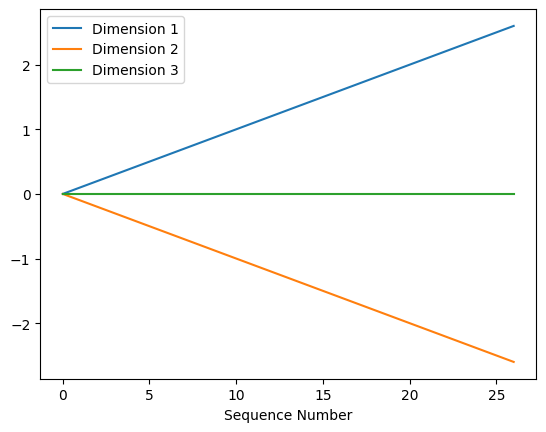

In [29]:
# Plot the first dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 0].numpy(), label="Dimension 1")

# Plot the second dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 1].numpy(), label="Dimension 2")

# Plot the third dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

# Label the x-axis as 'Sequence Number' to represent the position in the sequence
plt.xlabel("Sequence Number")

# Add a legend to the plot to identify which line corresponds to which dimension of positional encoding
plt.legend()

# Display the plot on screen
plt.show()

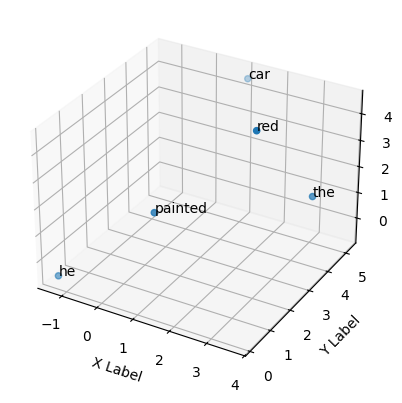

In [30]:
# After the positional encodings have been added, we need to detach the tensor from the computation graph
# and convert it to a NumPy array for visualization
# 'detach()' is necessary because 'embedded_x' requires gradients and we don't need them for plotting
# 'numpy()' converts the PyTorch tensor to a NumPy array
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to use as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the token embeddings with positional encodings
# The 'plot_embdings' function presumably takes the NumPy array of embeddings, token labels, and a vocabulary
# to plot the embeddings in a space where similar embeddings are closer together
plot_embdings(pos_embding_numpy, tokens, vocab)

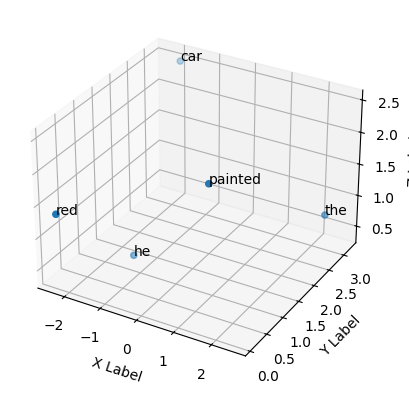

In [31]:
# Generate positional encodings using a sinusoidal function and concatenation
# The first dimension is encoded with a sine function
# The second and third dimensions are placeholders and are simply set to 1 (this is not typical in practice and likely serves as a simplified example)
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),  # Sinusoidal encoding for dimension 1
                0 * position + 1,                     # Constant encoding (1) for dimension 2
                0 * position + 1), axis=1)            # Constant encoding (1) for dimension 3

# Add the sinusoidal positional encodings to the token embeddings
# This step enriches the embeddings with information about the position of each token in the sequence
pos_embding = embedded_x + pe[0:samples, :]

# Prepare the positional embeddings for visualization
# 'detach()' is used to stop tracking all operations on 'pos_embding'
# 'numpy()' converts the tensor to a NumPy array suitable for plotting
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to get the labels for the embedding plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings using the plot function
# It is assumed the function will plot these embeddings in a way that illustrates the effects of adding positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

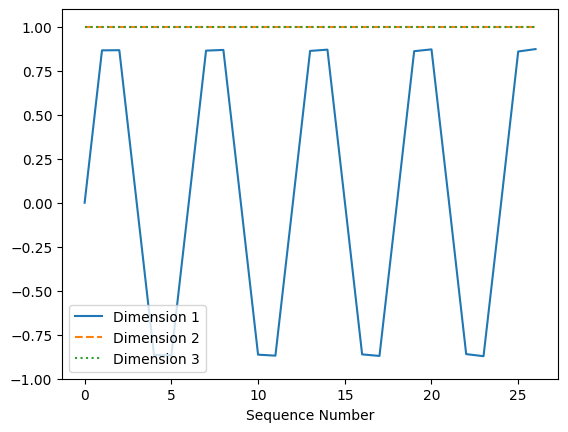

In [32]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

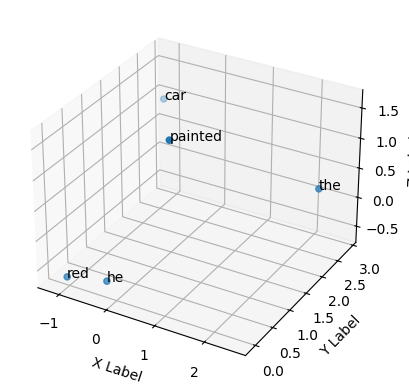

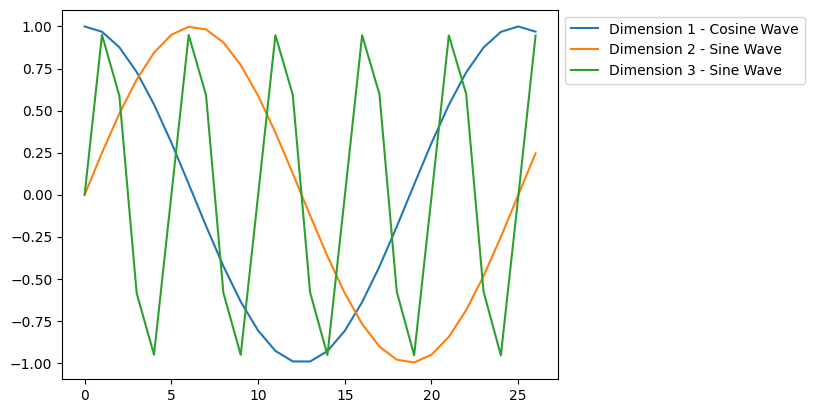

In [33]:
# Create positional encodings using sinusoidal functions
# Concatenate cosine and sine functions for different dimensions to form the encoding
pe = torch.cat((torch.cos(2 * 3.14 * position / 25),  # Cosine function for the first dimension
                torch.sin(2 * 3.14 * position / 25),  # Sine function for the second dimension
                torch.sin(2 * 3.14 * position / 5)), axis=1)  # Sine function with different frequency for the third dimension

# Add the generated positional encodings to the token embeddings
# This enriches the embeddings with positional information
pos_embding = embedded_x + pe[0:samples, :]

# Detach the embeddings from the computational graph and convert to NumPy for visualization
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the input text to be used as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings with positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

# Additionally, plot each dimension of the positional encodings to visualize their patterns
plt.plot(pe[:, 0].numpy(), label="Dimension 1 - Cosine Wave")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 - Sine Wave")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 - Sine Wave")

# Add a legend in the upper left corner outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

In [34]:
class PositionalEncoding(nn.Module):
    """Positional encoding module injects some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        # Initialize a buffer for the positional encodings (not a parameter, so it's not updated during training)
        pe = torch.zeros(vocab_size, n_embd)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        # Calculate the positional encodings once in log space
        pe = torch.cat((torch.cos(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 5)), 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
        # Note: 'pe' is a registered buffer and does not require gradients
        pos = x + self.pe[:x.size(0), :]
        return pos

class Head(nn.Module):
    """Self attention head."""
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # An embedding layer that converts input data (token indices) into dense vectors of fixed size
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # The positional encoding layer
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Layers to transform the position-encoded embeddings into queries, keys, and values
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        # Pass the input through the embedding layer to get fixed size dense embeddings
        embedded_x = self.embedding(x)
        # Pass the embeddings through the positional encoder
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate queries, keys, and values for the attention
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Calculate the attention scores as the dot product of queries and keys
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Query * Keys / normalization
        # Apply the softmax function to the attention scores to get probabilities
        w = F.softmax(w, dim=-1)
        # Multiply the attention weights with the values to get the output
        out = w @ v
        return out

In [35]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([5, 3])
Output: tensor([[-0.6975, -0.6135,  0.3027],
        [-0.5379, -0.7753,  0.2676],
        [-0.7413, -0.5851,  0.3071],
        [-0.7139, -0.5824,  0.3009],
        [-0.6674, -0.6623,  0.2934]], grad_fn=<MmBackward0>)


## Transformers in PyTorch
Create transfomer models using `nn.torch` library.

This code block creates an instance of the Transformer model from the nn (neural network) module in PyTorch. The nhead parameter specifies the number of heads in the multi-head attention mechanism, which is a crucial component of the Transformer architecture. In this case, it is set to 16.

The num_encoder_layers parameter determines the number of encoder layers in the Transformer model. Here, it is set to 12.

In [36]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

In [37]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))

In [38]:
out = transformer_model(src, tgt)

### MultiHead Attention

`nn.MultiheadAttention` is a module in PyTorch that implements the multi-head self-attention mechanism, a key component of the Transformer architecture. This attention mechanism enables the model to focus on different parts of the input sequence simultaneously, capturing various contextual dependencies and improving the model's ability to process complex natural language patterns.

The `nn.MultiheadAttention` module has three main inputs: `query`, `key`, and `value`.

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel.

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.

In [39]:
# Embedding dimension
embed_dim =4
# Number of attention heads
num_heads = 2
print("should be zero:",embed_dim %num_heads)
# Initialize MultiheadAttention
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,batch_first=False)

should be zero: 0


In [40]:
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

Attention Output Shape: torch.Size([10, 5, 4])


### TransformerEncoderLayer and TransformerEncoder

The `TransformerEncoderLayer` and `TransformerEncoder` are essential components of the Transformer architecture in PyTorch. These components work together to create a multi-layer, attention-based neural network.

#### TransformerEncoderLayer:
This is a single encoding layer in the Transformer architecture, consisting of two primary sub-layers: the Multi-head Self-Attention layer and the Feed-Forward Network (FFN). Each of these sub-layers is followed by a residual connection and layer normalization.

### TransformerEncoder:
The TransformerEncoder is a stack of multiple `TransformerEncoderLayer` instances. The encoder consists of N identical layers. N can be adjusted based on the desired complexity of the model.

The encoder takes an input sequence, applies positional encoding, and passes it through each of the TransformerEncoderLayers sequentially. This allows the model to learn rich, hierarchical representations of the input sequence, capturing both local and long-range dependencies.

TransformerEncoder accepts the following parameters:
- `src` (required): The sequence to the encoder.

- `mask` (Optional): The mask parameter is used to restrict the attention mechanism from considering certain positions in the input sequence. It is a binary tensor with the same shape as the input sequence. A value of 1 indicates that attention is allowed, while a value of 0 indicates that attention should be disregarded. This mask is particularly useful when working with triangular attention masks, where each position in the sequence can only attend to previous positions.

- `src_key_padding_mask` (Optional): The src_key_padding_mask parameter is used to specify which positions in the input sequence correspond to padding tokens. It is a binary tensor with shape (batch_size, sequence_length). A value of 1 indicates that the corresponding position contains a valid token, while a value of 0 indicates that the position contains a padding token. By providing this mask, the attention mechanism can ignore padding tokens and focus only on the meaningful parts of the input sequence. This parameter is particularly useful when dealing with variable-length sequences that have been padded to a fixed length.

In [41]:
# Embedding dimension
embed_dim = 4
# Number of attention h
num_heads = 2
# Checking if the embedding dimension is divisible by the number of heads, print("should be zero", embed_dim % num_h
# Number of encoder layers
num_layers = 6
# Initialize the encoder layer with specified embedding dimension and number of heads.
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
# Build the transformer encoder by stacking the encoder layer 6 times.
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

In [42]:
# Define sequence length as 10 and batch size as 5 for the input data.
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
# Generate random input tensor to simulate input embeddings for the transformer encoder.
x = torch.rand((seq_length, batch_size, embed_dim))
# Apply the transformer encoder to the input
encoded = transformer_encoder(x)
# Output the shape of the encoded tensor to verify the transformation.
print("Encoded Tensor Shape:", encoded.shape)

Encoded Tensor Shape: torch.Size([10, 5, 4])
